In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import random
import numpy as np

In [2]:
# read data
monday=pd.read_csv('monday.csv', sep=';')
tuesday=pd.read_csv('tuesday.csv', sep=';')
wednesday=pd.read_csv('wednesday.csv', sep=';')
thursday=pd.read_csv('thursday.csv', sep=';')
friday=pd.read_csv('friday.csv', sep=';')


In [3]:
class dframe:
    def df(day, name):
        day['timestamp'] = pd.to_datetime(day['timestamp'])
        day.sort_values(by=['customer_no', 'timestamp'], ascending=True, inplace=True)
        day['customer_id'] = name + day['customer_no'].astype(str)
        day.set_index('timestamp', inplace=True)
        day = day.groupby('customer_no').resample('1T').first()
        day.fillna(method="ffill", inplace=True)
        day.reset_index(drop=True, inplace=True)
        day['state_shift']=day['location'].shift(-1)
        day.rename(columns={'location': 'before', 'state_shift': 'after'}, inplace=True)
        day['after'].loc[(day['before'] == 'checkout')] = 'checkout'

        return day       

In [4]:
resampled = dframe
monday = resampled.df(monday, 'm')
tuesday = resampled.df(tuesday, 'tu')
wednesday = resampled.df(wednesday, 'w')
thursday = resampled.df(thursday, 'th')
friday = resampled.df(friday, 'f')

/Users/kashi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/kashi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/kashi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [5]:
frames=[monday, tuesday , wednesday , thursday ,friday]
df = pd.concat(frames, ignore_index=True)
print(df.shape)
df.head()

(53903, 4)


,customer_no,before,customer_id,after
0,1.0,dairy,m1,dairy
1,1.0,dairy,m1,checkout
2,1.0,checkout,m1,checkout
3,2.0,dairy,m2,dairy
4,2.0,dairy,m2,dairy


In [6]:
# declare possible states in a list
possible_states = ['checkout', 'dairy', 'drinks', 'fruit', 'spices']

In [7]:
# transition matrix
p=pd.crosstab(df['before'],df['after'],normalize=0)

In [8]:
p

after,checkout,dairy,drinks,fruit,spices
before,,,,,
checkout,1.000000,0.000000,0.000000,0.000000,0.000000
dairy,0.102684,0.737129,0.058628,0.050076,0.051483
drinks,0.215505,0.010899,0.598499,0.088012,0.087086
fruit,0.201070,0.095931,0.055166,0.597151,0.050681
spices,0.149912,0.193564,0.163135,0.091126,0.402262


In [9]:
p.to_csv('transition_matrix.csv')

In [10]:
# All transition states
transition_matrix = p.to_dict(orient='index')
for key in transition_matrix.keys():
    transition_matrix[key] = list(transition_matrix[key].values())

In [11]:
# All transition states as global variables
STATES_ALL = ['checkout','dairy','drinks','fruit','spices']
TRANSITION_MATRIX_ALL = transition_matrix
STATES_START = ['dairy','drinks','fruit','spices']


<h3> Customer class</h3>
_______________________________________

In [12]:
class Customer:
    def __init__(self):
        self.history = random.choices(STATES_START)             # first state shall not be checkout, so a random choice from the other states is made 

    # gets next state based on the transition matrix probabilities until checkout is reached
    def next_state(self):
        first_state= self.history[0] 
        next_state='fruit'
        while next_state != ['checkout']:
            next_state = random.choices(STATES_ALL, weights=TRANSITION_MATRIX_ALL[first_state])
            self.history.append(next_state[0])
            if next_state == 'check_out':
                break
        return self.history


In [13]:
#example
Customer().next_state()

['fruit', 'fruit', 'dairy', 'fruit', 'drinks', 'checkout']

<h3> Supermarket class</h3>
_______________________________________

two Supermarket classes are made: (we have to choose which one we want to use )
    <li> 1. first one generates the new customers then gives them time sequentially</li>
    <li> 2. second time generates new customers for all in the same time interval (This one should be the right one) </li>

In [14]:
# new customers concatenated -> time sequential
class Supermarkt_1:
    def __init__ (self,number_customer:int):
        self.number_customer=number_customer

    # Calls Customer class and generates new customer
    def new_customer_df(self):
        customer_df = pd.DataFrame(columns=['location'])
        customer_df['location']=Customer().next_state()
        return customer_df

    # generates multiple customers, and gives them customer no
    def simulate_customers(self):       
        all_customers=pd.DataFrame([])
        for i in range (self.number_customer):

            df=self.new_customer_df()
            customer_no = [i+1] * len(df)
            df['customer_no']=customer_no                       #generate customer_no
            all_customers =all_customers.append(df, ignore_index=True)                 
        return  all_customers 
  
    # generates multiple customers, timestamp included
    def simulate_customers_time(self):
        start_date='2022-02-01 07:00:00'
        df= self.simulate_customers()
        date_range = pd.date_range(start_date, periods=len(df), freq = '1T')
        df['timestamp'] =date_range
        column_names = ['timestamp', 'customer_no', 'location']
        df = df.reindex(columns=column_names)     
        return df

In [15]:
# new customers in same time interval (I think this is the one we need)
class Supermarkt:
    def __init__ (self,number_customer:int,start_date='2022-02-01 07:00:00',time_delta='1T'):
        self.number_customer=number_customer
        self.start_date =start_date 
        self.time_delta=time_delta

    # Calls Customer class and generates new customer
    def new_customer_df(self):
        # new customer
        customer_df = pd.DataFrame(columns=['location'])
        customer_df['location']=Customer().next_state()
        # Giving the new_customer df timestamp
        date_range = pd.date_range(self.start_date, periods=len(customer_df), freq = self.time_delta)
        customer_df['timestamp'] =date_range
        column_names = ['timestamp', 'customer_no', 'location']
        customer_df= customer_df.reindex(columns=column_names) 
        return customer_df

    # generates multiple customers, and gives them customer no
    def simulate_customers(self):       
        all_customers=pd.DataFrame([])
        for i in range (self.number_customer):
            df=self.new_customer_df()
            customer_no = [i+1] * len(df)
            df['customer_no']=customer_no                       #generate customer_no
            all_customers =all_customers.append(df, ignore_index=True)                 
        return  all_customers 
  


In [16]:
simulation_test_correct=Supermarkt(3).simulate_customers()
simulation_test_correct

,timestamp,customer_no,location
0,2022-02-01 07:00:00,1,dairy
1,2022-02-01 07:01:00,1,dairy
2,2022-02-01 07:02:00,1,dairy
3,2022-02-01 07:03:00,1,dairy
4,2022-02-01 07:04:00,1,dairy
5,2022-02-01 07:05:00,1,dairy
6,2022-02-01 07:06:00,1,fruit
7,2022-02-01 07:07:00,1,dairy
8,2022-02-01 07:08:00,1,spices
9,2022-02-01 07:09:00,1,dairy


<h2> This is where the next step (visualization) should take place </h2>
course material : <a href=https://spiced.space/euclidean-eukalyptus/ds-course/chapters/project_markov/numpy/visualization.html> Link here</a> <br/><br/>
Use class supermarket<br/>
_____________________________________________________________________________________________________________________________


In [17]:
# start working on the code from here

<h5> Using the first Supermarket class to generate many customers (probabaly not needed) </h5>
_______________________________________________________________________________________________

In [18]:
#example
test=Supermarkt_1(3).simulate_customers_time()
test

,timestamp,customer_no,location
0,2022-02-01 07:00:00,1,fruit
1,2022-02-01 07:01:00,1,fruit
2,2022-02-01 07:02:00,1,fruit
3,2022-02-01 07:03:00,1,checkout
4,2022-02-01 07:04:00,2,spices
5,2022-02-01 07:05:00,2,dairy
6,2022-02-01 07:06:00,2,spices
7,2022-02-01 07:07:00,2,spices
8,2022-02-01 07:08:00,2,dairy
9,2022-02-01 07:09:00,2,spices


In [ ]:
#example
simulation_test=Supermarkt_1(10000).simulate_customers_time()
simulation_test.to_csv('simulation_test_10000.csv')


In [ ]:
simulation_test.groupby(['location']).count()

,timestamp,customer_no
location,,
checkout,10000,10000
dairy,24184,24184
drinks,14456,14456
fruit,13511,13511
spices,11919,11919


<AxesSubplot:xlabel='location'>

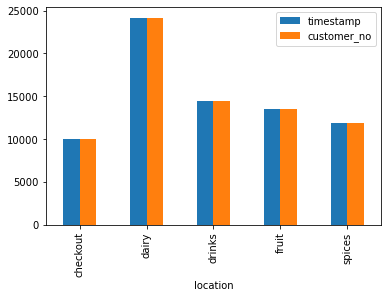

In [ ]:
simulation_test.groupby(['location']).count().plot.bar()